$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \cY {\mathcal{Y}}$
$\def \cM {\mathcal{M}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$
$\newcommand{\rd}{\mathop{}\!\mathrm{d}}$

# Alternating minimization for state estimation


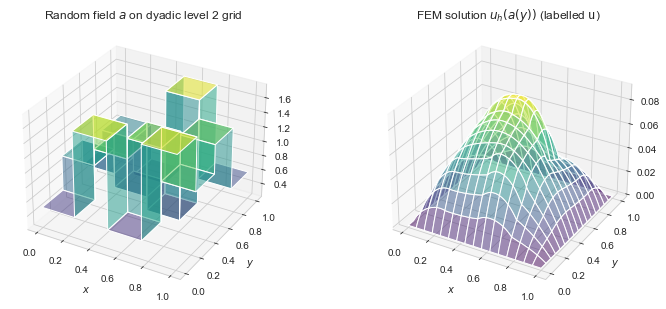

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Latex, display

import sys
sys.path.append("../../")
import pyhilbert as hil
import pyredmod as rm

import os.path
from labellines import *
sns.set_style("whitegrid")
cp = sns.color_palette()

%matplotlib inline

def make_soln(points, field_space, fem_space, a_bar=1.0, c=0.5, f=1.0, verbose=False):
    
    solns = hil.Basis(np.zeros((H1_fine.n, len(points))), space=H1_fine)
    fields = []
    
    for i, p in enumerate(np.atleast_2d(points)):
        field = hil.Vector(a_bar + c * p, space=field_space)
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = hil.DyadicFEMSolver(fem_space = fem_space, rand_field = field, f = 1)
        fem_solver.solve()
        solns._values[:,i] = fem_solver.u.values
        
    return solns, fields

fem_div = 7
H1_fine = hil.H1DyadicSq(fem_div)
field_div = 2
L2_coarse = hil.L2DyadicSq(field_div)
a_bar = 1.0
c = 0.9
side_n = 2**field_div
d = side_n * side_n
y_range = np.zeros((d,2))
y_range[:,0] = -1.0
y_range[:,1] = 1.0

def diffusion_pde(points):
    solns, fields = make_soln(points, field_space=L2_coarse, fem_space=H1_fine, a_bar=a_bar, c=c)
    return solns

np.random.seed(5)
y = np.random.random((1,d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
u, a = make_soln(y, field_space=L2_coarse, fem_space=H1_fine, a_bar=a_bar, c=c)
u = u[0]; a = a[0]
                           
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(1, 2, 2, projection='3d')
u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u}$)')
plt.show()

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

# Lets test the alternating minimization

This scheme involves alternately finding $y^*_n$, our best guess for the parameters, and $v^*_n$, the nearest point that satisfies the data that is closest to $u(y^*_n)$ in the sense of the residual.

The idea comes from the observation that
$$
\begin{aligned}
\| u^* - u(y) \|_V 
&\sim \| \mathrm{div} (a(y) \nabla (u^* - u(y))) \|_{V'} \\
&= \| \mathrm{div} (a(y) \nabla u^*) + f \|_{V'} \\
\end{aligned}
$$

So now we want to minimise this last expression, or find succesive
$$
\begin{aligned}
y^*_{n+1} &= \arg\min_{y \in \cY} \| \mathrm{div} (a(y) \nabla u^*_n) + f \|_{V'} \\
u^*_{n+1} &= \arg\min_{P_W u = w} \| \mathrm{div} (a(y^*_{n+1}) \nabla u) + f \|_{V'}
\end{aligned}
$$

We take our field $a(y)$ to be of the form $a(y) = \bar a + \sum_{j=1}^d y_j \, \psi_j$

As described we can find   $y^*_n$ through the following
$$
y^*_{n+1} = \begin{aligned} \label{eq:min}
{\arg \min}_{y\in \cY} \left\| \mathrm{div} (\bar a \nabla u^*_n)  + f + \sum_{i=1}^d y_i \mathrm{div}(\psi_i \nabla u^*_n) \right\|_{V'}^2
= {\arg \min}_{y\in \cY} \left\| \phi_0 + \sum_{i=1}^d y_i \phi_j \right\|_{V}^2
\end{aligned}
$$

where now the $\phi_j \in V$ are the representers of $\mathrm{div}(\psi_i \nabla u^*_n)$ and $\phi_0$ of $\mathrm{div} (\bar a \nabla u^*_n) + f$. We calculate this explicitly through the usual Galerkin projection:

$$
\int \nabla \phi_0 \cdot \nabla v \rd x = \int f v \rd x + \int \bar a \nabla u^*_n \cdot \nabla v \rd x
$$
and
$$
\int \nabla \phi_j \cdot \nabla v \rd x = \int \psi_j \nabla u^*_n \cdot \nabla v \rd x
$$

Then the solution to the minimisation problem is a linear system

In [8]:
N_tr = 200
N_te = 10

np.random.seed(1)
#points_tr = np.random.random((N_tr, d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
#us_tr = diffusion_pde(points_tr)
points_te = np.random.random((N_te, d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
us_te = diffusion_pde(points_te)

In [9]:
y_guesser = hil.DyadicGuesser(field_mean=a_bar, field_mult=c, fem_space=H1_fine, field_space=L2_coarse, y_bounds=y_range)

In [10]:
# local_width is the width of the measurement squares in terms of FEM mesh squares
width_div = 2
spacing_div = 5
L2_loc = hil.L2DyadicSq(fem_div)

Wm_reg, Wm_reg_L2, Wloc_reg = rm.make_local_avg_grid_basis(width_div, spacing_div, fem_div, return_map=True)
Wm = Wm_reg #.orthonormalise()
m = Wm.n
print(f'm={m}')
    
ws_te = Wm.A @ us_te

m=16


# Lets test $u(y)$ and $y$ recovery with $u_0 = w$.

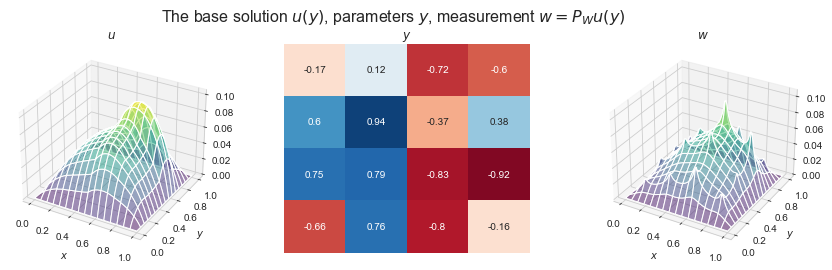

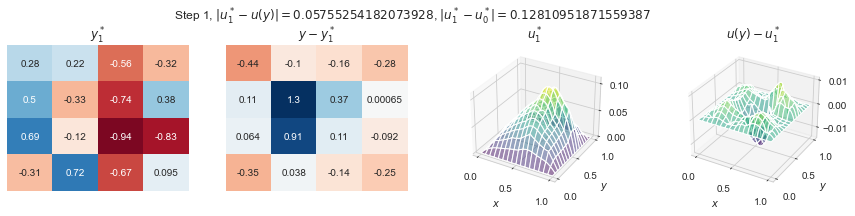

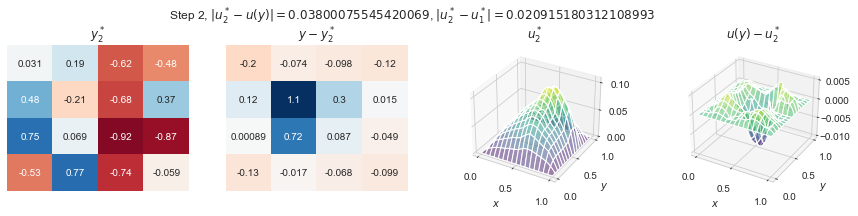

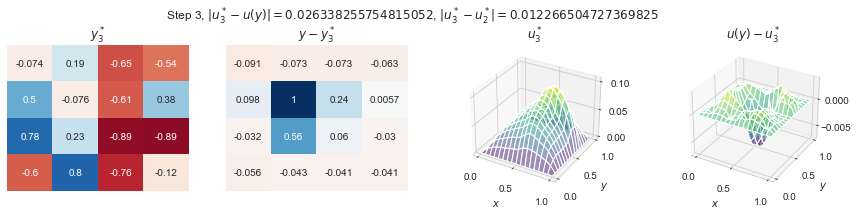

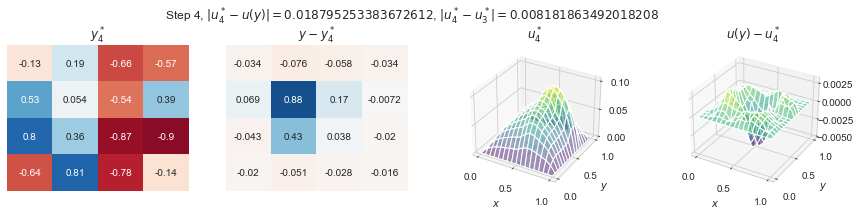

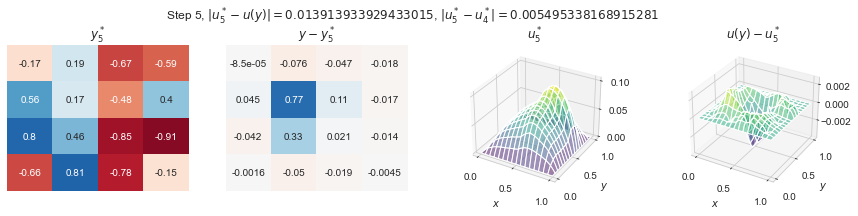

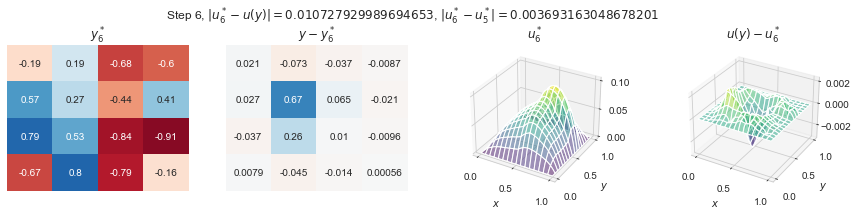

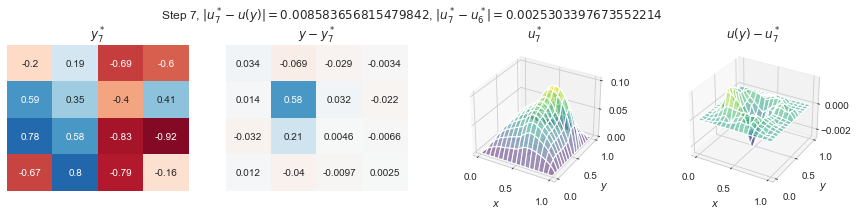

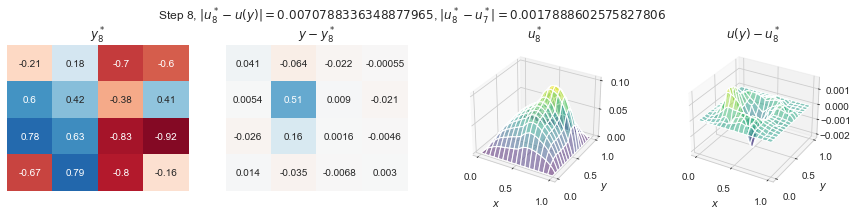

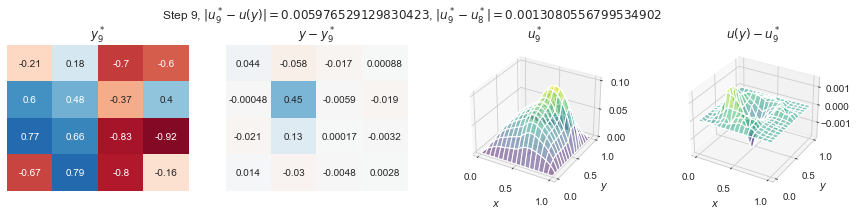

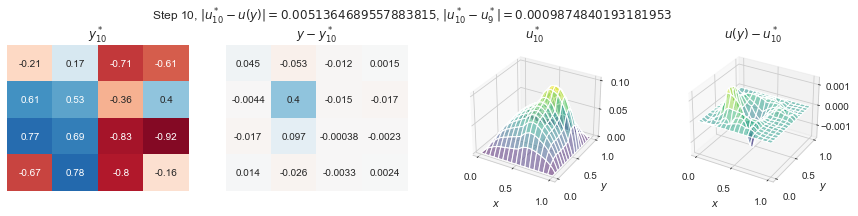

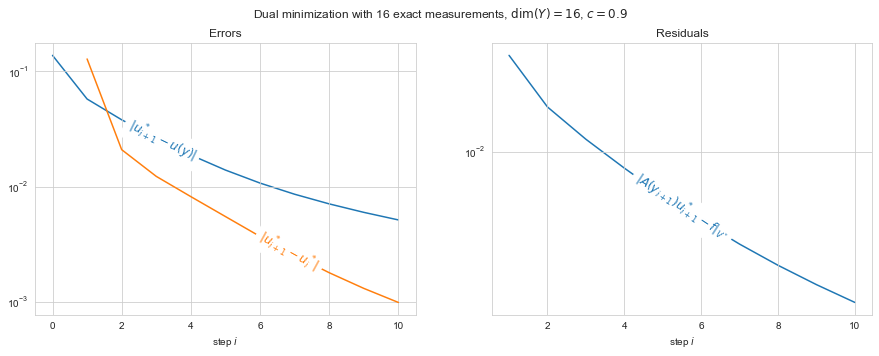

In [24]:
choice = 1
n_steps = 10
u_te = us_te[choice]
y_te = points_te[choice]
w_te = ws_te[:,choice]
w = Wm_reg.dot_to_projection(w_te)

#display(Latex(rf'The base solution $u(y)$, parameters $y$, measurement $w = P_W u(y)$'))
fig = plt.figure(figsize=(15, 4))
fig.suptitle(rf'The base solution $u(y)$, parameters $y$, measurement $w = P_W u(y)$', fontsize=16)
ax = fig.add_subplot(1, 3, 1, projection='3d')
u_te.plot(ax, title=r'$u$')
ax = fig.add_subplot(1, 3, 2)
sns.heatmap(y_te.reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
ax.set_title(r'$y$')
ax = fig.add_subplot(1, 3, 3, projection='3d')
w.plot(ax, title=r'$w$')
plt.subplots_adjust(top=0.85)
plt.savefig(f'./figs/dual_min_start_unpert_{choice}.pdf')
plt.show()

u_star_n = w
y_star_n = None
u_star_err = np.zeros(n_steps+1)
u_star_step = np.zeros(n_steps)
y_resids = np.zeros(n_steps)
u_resids = np.zeros(n_steps)
u_star_err[0] = (u_te - u_star_n).norm()
for i in range(n_steps):    
    # First the y guess is made from the projection
    y_star_n, y_resids[i] = y_guesser.nearest_params_resid(u_star_n)
    u_star_n_prev = u_star_n
    u_star_n, u_resids[i] = y_guesser.nearest_resid(y_star_n, w, w_te, Wm_reg_L2)
    u_star_err[i+1] = (u_te - u_star_n).norm()
    u_star_step[i] = (u_star_n - u_star_n_prev).norm()

    #display(Latex(rf'Step {i+1}, $\| u^*_{{{i+1}}} - u(y) \| = {u_star_err[i+1]}$, $\| u^*_{{{i+1}}} - u^*_{{{i}}} \| = {u_star_step[i]}$'))    
    fig = plt.figure(figsize=(15, 3))
    fig.suptitle(rf'Step {i+1}, $\| u^*_{{{i+1}}} - u(y) \| = {u_star_err[i+1]}$, $\| u^*_{{{i+1}}} - u^*_{{{i}}} \| = {u_star_step[i]}$', fontsize=12)
    ax = fig.add_subplot(1, 4, 1)
    sns.heatmap((y_star_n).reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
    ax.set_title(rf'$y^*_{{{i+1}}}$')
    ax = fig.add_subplot(1, 4, 2)
    sns.heatmap((y_te - y_star_n).reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
    ax.set_title(rf'$y - y^*_{{{i+1}}}$')
    ax = fig.add_subplot(1, 4, 3, projection='3d')
    u_star_n.plot(ax, title=rf'$u^*_{{{i+1}}}$')
    ax = fig.add_subplot(1, 4, 4, projection='3d')
    (u_te - u_star_n).plot(ax, title=rf'$u(y) - u^*_{{{i+1}}}$')
    plt.subplots_adjust(top=0.8)
    plt.savefig(f'./figs/dual_min_step_unpert_{choice}_{i}.pdf')
    plt.show()

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
plt.semilogy(range(n_steps+1), u_star_err, label=rf'$\| u^*_{{i+1}} - u(y) \|$', color=cp[0], zorder=0)
plt.semilogy(range(1,n_steps+1), u_star_step, label=rf'$\| u^*_{{i+1}} - u^*_{{i}} \|$', color=cp[1], zorder=1)
ax = plt.gca()
xmin,xmax = ax.get_xlim()
labelLines(plt.gca().get_lines(),zorder=10+1, fontsize=12)
plt.xlabel(rf'step $i$')
fig.suptitle(rf'Dual minimization with {Wm_reg.n} exact measurements, $\mathrm{{dim}}(Y)={d}$, $c = {c}$')
plt.title(rf'Errors') 
ax = fig.add_subplot(1, 2, 2)
#plt.semilogy(range(1,n_steps+1), y_resids, label=rf'$\| A(y_{{i+1}}) u^*_{{i}} - f \|_{{V^*}}$', color=cp[0], zorder=0)
plt.semilogy(range(1,n_steps+1), u_resids, label=rf'$\| A(y_{{i+1}}) u^*_{{i+1}} - f  \|_{{V^*}}$', color=cp[0], zorder=0)
plt.xlabel(rf'step $i$')
plt.title(rf'Residuals')
ax = plt.gca()
xmin,xmax = ax.get_xlim()
labelLines(plt.gca().get_lines(),zorder=10+1, fontsize=12)
plt.savefig(f'./figs/dual_min_error_unpert.pdf')
plt.savefig(f'./figs/dual_min_error_unpert.png')
plt.show()

# We evidently don't get perfect recovery when $w$ is perturbed...

Here we take measurements $\ell_i(u(y)) = \langle \omega_i, u(y) \rangle + \eta_i$ where the vector $\eta$ is uncorrelated Gaussian noise.

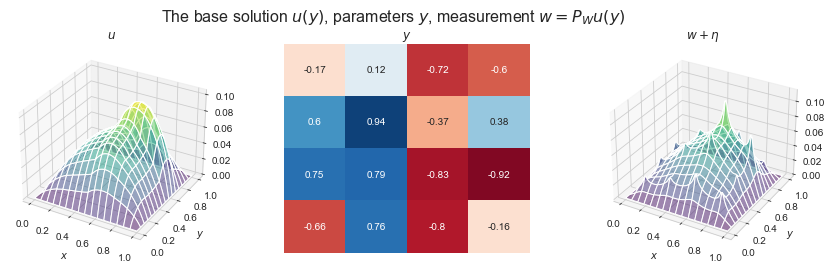

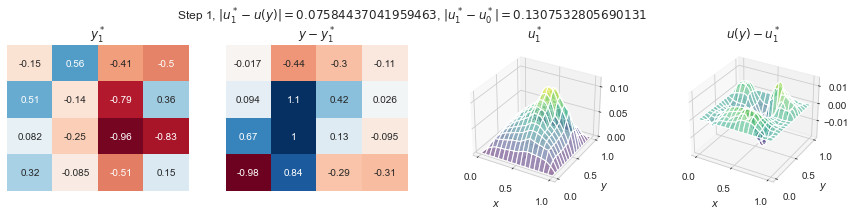

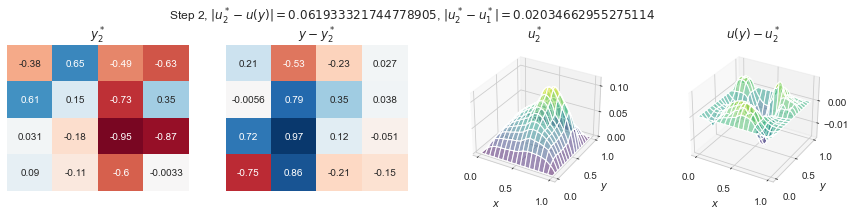

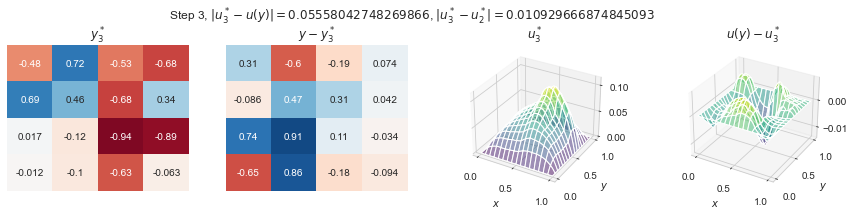

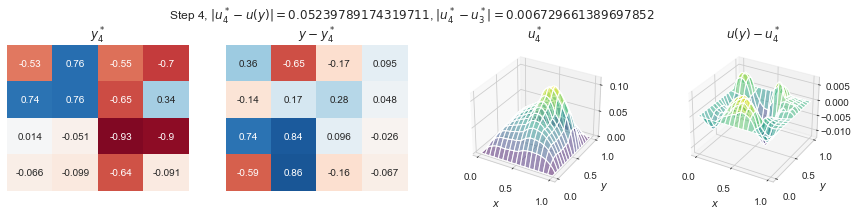

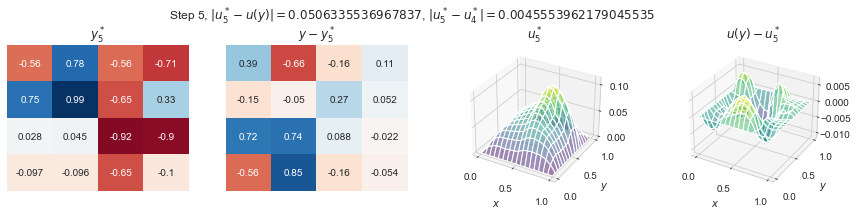

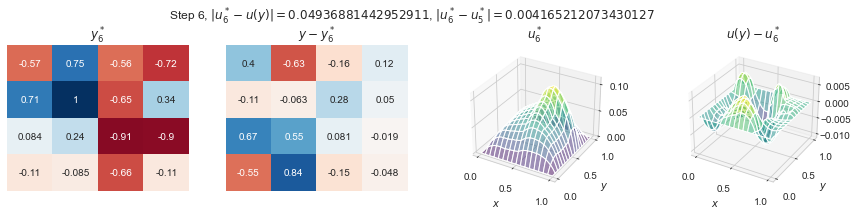

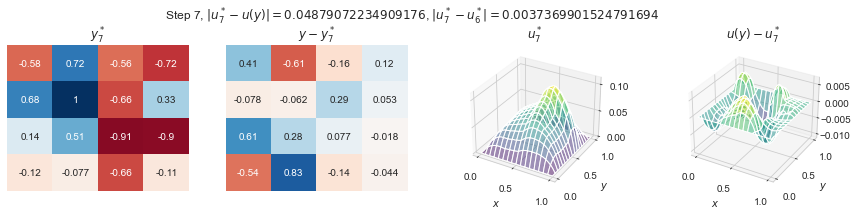

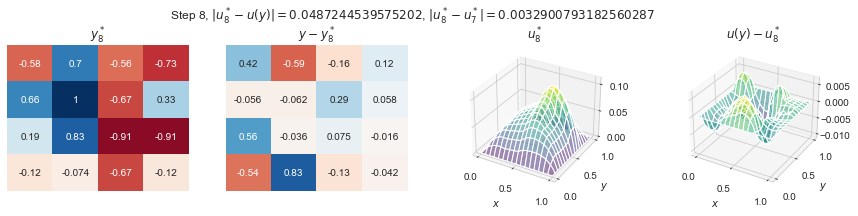

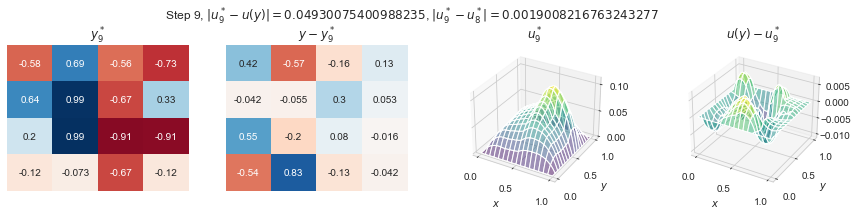

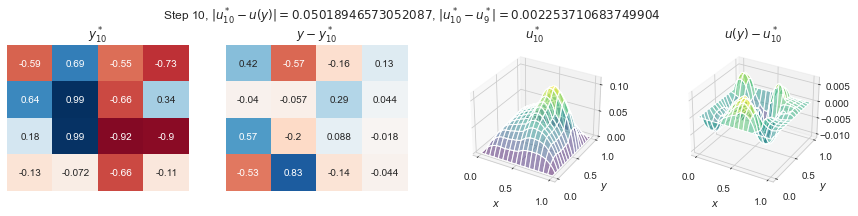

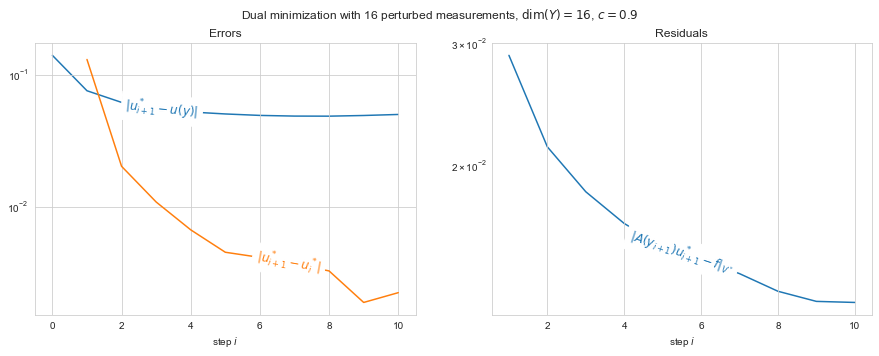

In [22]:
choice = 1
n_steps = 10
u_te = us_te[choice]
y_te = points_te[choice]
w_te = ws_te[:,choice]
w = Wm_reg.dot_to_projection(w_te)

w_pert_coeffs = w_te + np.random.normal(scale=0.02 * np.linalg.norm(w_te) , size=w_te.shape)
w_pert = Wm_reg.dot_to_projection(w_pert_coeffs)

#display(Latex(rf'The base solution $u(y)$, parameters $y$, measurement $w = P_W u(y)$, and perturbed measurement $w+\eta$ ($=u^*_0$)'))
fig = plt.figure(figsize=(15, 4))
fig.suptitle(rf'The base solution $u(y)$, parameters $y$, measurement $w = P_W u(y)$', fontsize=16)
ax = fig.add_subplot(1, 3, 1, projection='3d')
u_te.plot(ax, title=r'$u$')
ax = fig.add_subplot(1, 3, 2)
sns.heatmap(y_te.reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
ax.set_title(r'$y$')
ax = fig.add_subplot(1, 3, 3, projection='3d')
w_pert.plot(ax, title=r'$w + \eta$')
plt.subplots_adjust(top=0.85)
plt.savefig(f'./figs/dual_min_start_pert_{choice}.pdf')
plt.show()

u_star_n = w_pert
y_star_n = None
u_star_err = np.zeros(n_steps+1)
u_star_step = np.zeros(n_steps)
y_resids = np.zeros(n_steps)
u_resids = np.zeros(n_steps)
u_star_err[0] = (u_te - u_star_n).norm()
for i in range(n_steps):    
    # First the y guess is made from the projection
    y_star_n, y_resids[i] = y_guesser.nearest_params_resid(u_star_n)
    u_star_n_prev = u_star_n
    u_star_n, u_resids[i] = y_guesser.nearest_resid(y_star_n, w_pert, w_pert_coeffs, Wm_reg_L2)
    u_star_err[i+1] = (u_te - u_star_n).norm()
    u_star_step[i] = (u_star_n - u_star_n_prev).norm()

    #display(Latex(rf'Step {i+1}, $\| u^*_{{{i+1}}} - u(y) \| = {u_star_err[i+1]}$, $\| u^*_{{{i+1}}} - u^*_{{{i}}} \| = {u_star_step[i]}$'))
    fig = plt.figure(figsize=(15, 3))
    fig.suptitle(rf'Step {i+1}, $\| u^*_{{{i+1}}} - u(y) \| = {u_star_err[i+1]}$, $\| u^*_{{{i+1}}} - u^*_{{{i}}} \| = {u_star_step[i]}$', fontsize=12)
    ax = fig.add_subplot(1, 4, 1)
    sns.heatmap((y_star_n).reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
    ax.set_title(rf'$y^*_{{{i+1}}}$')
    ax = fig.add_subplot(1, 4, 2)
    sns.heatmap((y_te - y_star_n).reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
    ax.set_title(rf'$y - y^*_{{{i+1}}}$')
    ax = fig.add_subplot(1, 4, 3, projection='3d')
    u_star_n.plot(ax, title=rf'$u^*_{{{i+1}}}$')
    ax = fig.add_subplot(1, 4, 4, projection='3d')
    (u_te - u_star_n).plot(ax, title=rf'$u(y) - u^*_{{{i+1}}}$')
    plt.subplots_adjust(top=0.8)
    plt.savefig(f'./figs/dual_min_step_pert_{choice}_{i}.pdf')
    plt.show()
    

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
plt.semilogy(range(n_steps+1), u_star_err, label=rf'$\| u^*_{{i+1}} - u(y) \|$', color=cp[0], zorder=0)
plt.semilogy(range(1,n_steps+1), u_star_step, label=rf'$\| u^*_{{i+1}} - u^*_{{i}} \|$', color=cp[1], zorder=1)
ax = plt.gca()
xmin,xmax = ax.get_xlim()
labelLines(plt.gca().get_lines(),zorder=10+1, fontsize=12)
plt.xlabel(rf'step $i$')
fig.suptitle(rf'Dual minimization with {Wm_reg.n} perturbed measurements, $\mathrm{{dim}}(Y)={d}$, $c = {c}$')
plt.title(rf'Errors')
ax = fig.add_subplot(1, 2, 2)
#plt.semilogy(range(1,n_steps+1), y_resids, label=rf'$\| A(y_{{i+1}}) u^*_{{i}} - f \|_{{V^*}}$', color=cp[0], zorder=0)
plt.semilogy(range(1,n_steps+1), u_resids, label=rf'$\| A(y_{{i+1}}) u^*_{{i+1}} - f  \|_{{V^*}}$', color=cp[0], zorder=0)
plt.xlabel(rf'step $i$')
plt.title(rf'Residuals') 
ax = plt.gca()
xmin,xmax = ax.get_xlim()
labelLines(plt.gca().get_lines(),zorder=10+1, fontsize=12)
plt.savefig(f'./figs/dual_min_error_pert.pdf')
plt.savefig(f'./figs/dual_min_error_pert.png')
plt.show()

# Now we apply the guesser with some missing measurements

We take out the last two measurements (which are in the top right corner of the $u$ plot or the bottom right of the parameter plot)

In [13]:
Wm_trunc = Wm_reg[:14] #.orthonormalise()
Wm_trunc_L2 = Wm_reg_L2[:14]
ws_trunc_te = Wm_trunc.A @ us_te

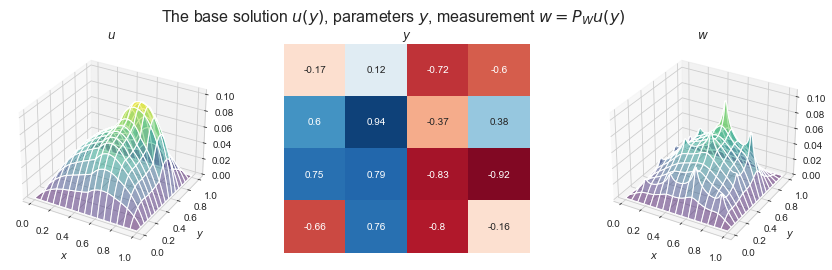

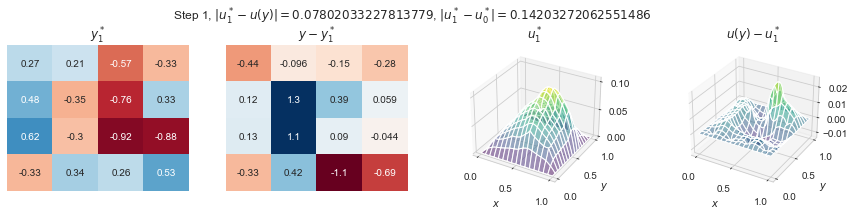

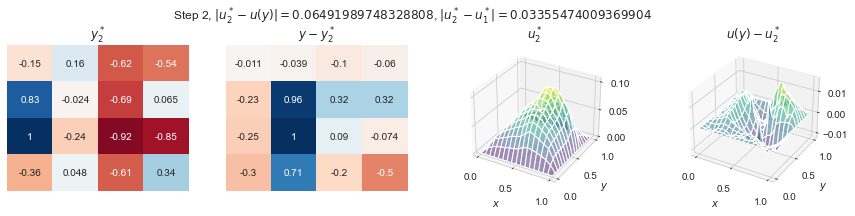

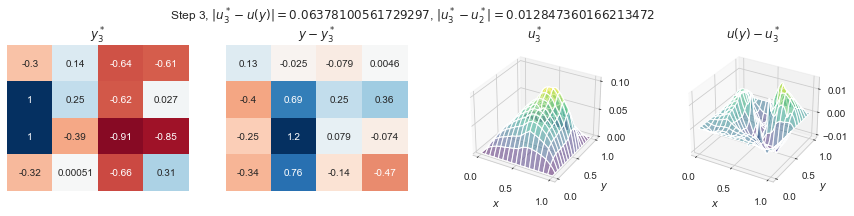

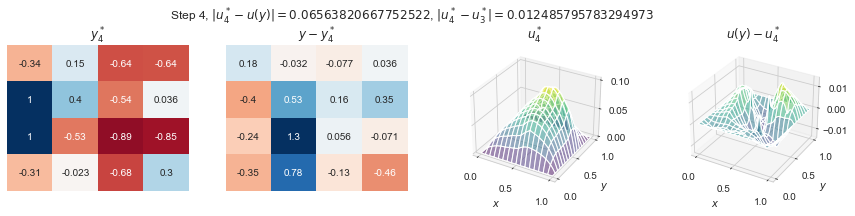

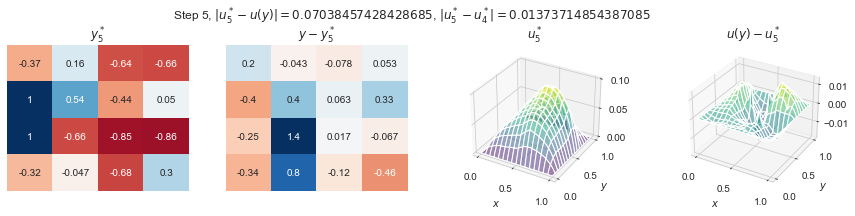

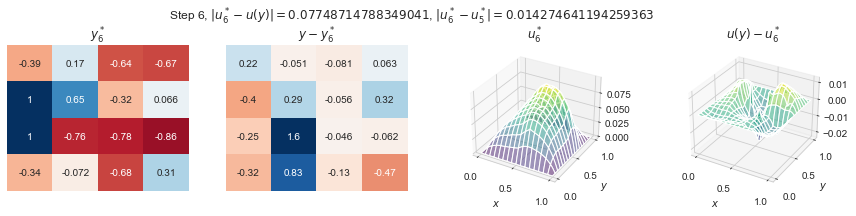

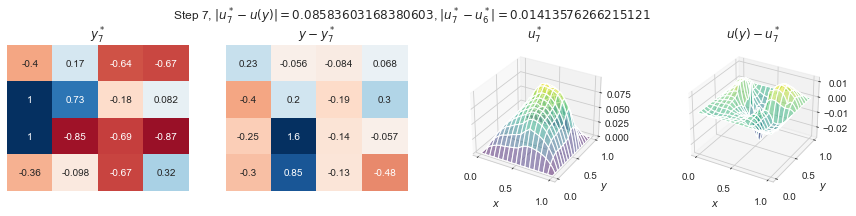

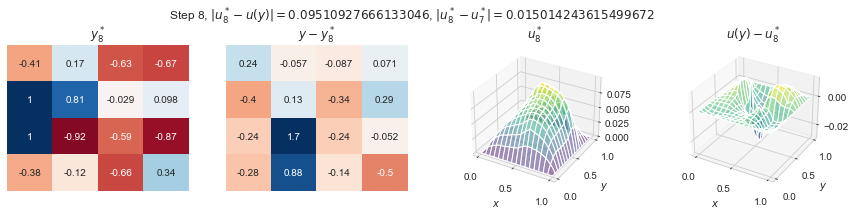

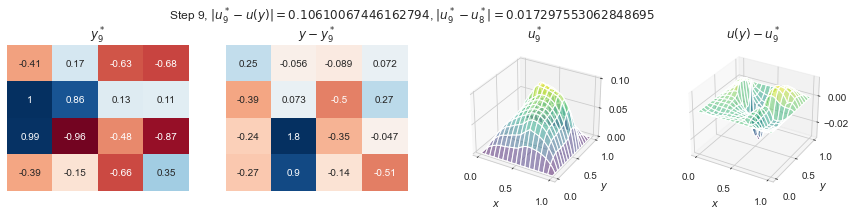

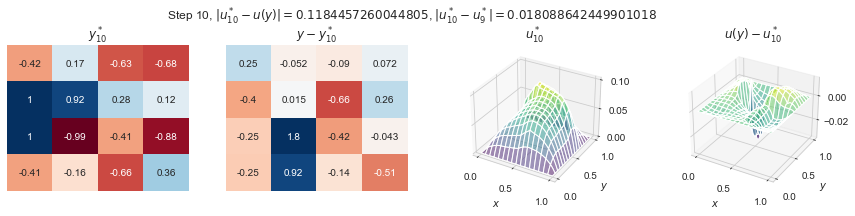

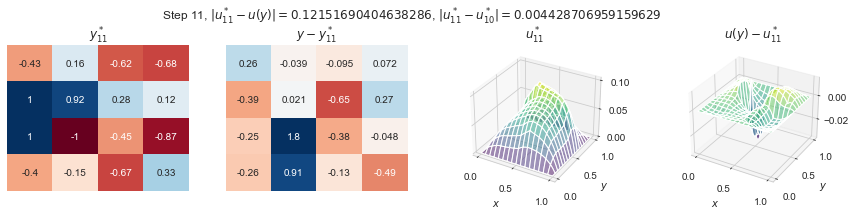

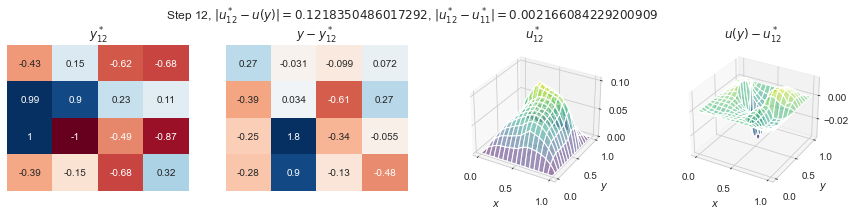

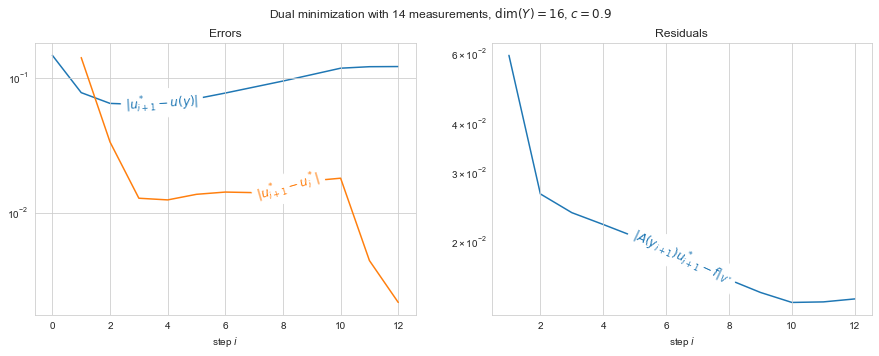

In [21]:
choice = 1
n_steps = 12
u_te = us_te[choice]
y_te = points_te[choice]
w_te = ws_trunc_te[:,choice]
w = Wm_trunc.dot_to_projection(w_te)

#display(Latex(rf'The base solution $u(y)$, parameters $y$, measurement $w = P_W u(y)$'))
fig = plt.figure(figsize=(15, 4))
fig.suptitle(rf'The base solution $u(y)$, parameters $y$, measurement $w = P_W u(y)$', fontsize=16)
ax = fig.add_subplot(1, 3, 1, projection='3d')
u_te.plot(ax, title=r'$u$')
ax = fig.add_subplot(1, 3, 2)
sns.heatmap(y_te.reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
ax.set_title(r'$y$')
ax = fig.add_subplot(1, 3, 3, projection='3d')
w.plot(ax, title=r'$w$')
plt.subplots_adjust(top=0.85)
plt.savefig(f'./figs/dual_min_start_unpert_{choice}.pdf')
plt.show()

u_star_n = w
y_star_n = None
u_star_err = np.zeros(n_steps+1)
u_star_step = np.zeros(n_steps)
y_resids = np.zeros(n_steps)
u_resids = np.zeros(n_steps)
u_star_err[0] = (u_te - u_star_n).norm()
for i in range(n_steps):    

    # First the y guess is made from the projection
    y_star_n, y_resids[i] = y_guesser.nearest_params_resid(u_star_n)
    u_star_n_prev = u_star_n
    u_star_n, u_resids[i] = y_guesser.nearest_resid(y_star_n, w_pert, w_pert_coeffs, Wm_reg_L2)
    u_star_err[i+1] = (u_te - u_star_n).norm()
    u_star_step[i] = (u_star_n - u_star_n_prev).norm()

    #display(Latex(rf'Step {i+1}, $\| u^*_{{{i+1}}} - u(y) \| = {u_star_err[i+1]}$, $\| u^*_{{{i+1}}} - u^*_{{{i}}} \| = {u_star_step[i]}$'))    
    fig = plt.figure(figsize=(15, 3))
    fig.suptitle(rf'Step {i+1}, $\| u^*_{{{i+1}}} - u(y) \| = {u_star_err[i+1]}$, $\| u^*_{{{i+1}}} - u^*_{{{i}}} \| = {u_star_step[i]}$', fontsize=12)
    ax = fig.add_subplot(1, 4, 1)
    sns.heatmap((y_star_n).reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
    ax.set_title(rf'$y^*_{{{i+1}}}$')
    ax = fig.add_subplot(1, 4, 2)
    sns.heatmap((y_te - y_star_n).reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
    ax.set_title(rf'$y - y^*_{{{i+1}}}$')
    ax = fig.add_subplot(1, 4, 3, projection='3d')
    u_star_n.plot(ax, title=rf'$u^*_{{{i+1}}}$')
    ax = fig.add_subplot(1, 4, 4, projection='3d')
    (u_te - u_star_n).plot(ax, title=rf'$u(y) - u^*_{{{i+1}}}$')
    plt.subplots_adjust(top=0.8)
    plt.savefig(f'./figs/dual_min_step_unpert_{choice}_{i}.pdf')
    plt.show()

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
plt.semilogy(range(n_steps+1), u_star_err, label=rf'$\| u^*_{{i+1}} - u(y) \|$', color=cp[0], zorder=0)
plt.semilogy(range(1,n_steps+1), u_star_step, label=rf'$\| u^*_{{i+1}} - u^*_{{i}} \|$', color=cp[1], zorder=1)
ax = plt.gca()
xmin,xmax = ax.get_xlim()
labelLines(plt.gca().get_lines(),zorder=10+1, fontsize=12)
plt.xlabel(rf'step $i$')
fig.suptitle(rf'Dual minimization with {Wm_trunc.n} measurements, $\mathrm{{dim}}(Y)={d}$, $c = {c}$')
plt.title(rf'Errors')      
ax = fig.add_subplot(1, 2, 2)
#plt.semilogy(range(1,n_steps+1), y_resids, label=rf'$\| A(y_{{i+1}}) u^*_{{i}} - f \|_{{V^*}}$', color=cp[0], zorder=0)
plt.semilogy(range(1,n_steps+1), u_resids, label=rf'$\| A(y_{{i+1}}) u^*_{{i+1}} - f  \|_{{V^*}}$', color=cp[0], zorder=0)
plt.xlabel(rf'step $i$')
plt.title(rf'Residuals') 
ax = plt.gca()
xmin,xmax = ax.get_xlim()
labelLines(plt.gca().get_lines(),zorder=10+1, fontsize=12)
plt.savefig(f'./figs/dual_min_error_Wm_defficient.pdf')
plt.savefig(f'./figs/dual_min_error_Wm_defficient.png')
plt.show()